In [48]:
%reload_ext autoreload
import numpy as np
from cloud_env_simulator import CloudEnvironment
from dqn_agent import DQNAgent
import torch
import matplotlib.pyplot as plt

from configuration import TEST_EPISODE_COUNT, EPISODE_LENGTH, MODEL_PATH, REWARD_PATH, MAX_SERVER_COUNT

In [49]:
class RoundRobin:
    def __init__(self):
        self.pointer = 0

    def select_action(self, num_servers):
        action = self.pointer % num_servers
        self.pointer += 1
        return action


class RandomPolicy:
    def select_action(self, num_servers):
        return np.random.randint(0, num_servers)


class LeastConnections:
    def select_action(self, queues, num_servers):
        return np.argmin(queues[:num_servers])


class ThresholdAutoscaler:
    def __init__(self, scale_up_threshold = 0.75, scale_down_threshold = 0.25):
        self.scale_up_threshold = scale_up_threshold
        self.scale_down_threshold = scale_down_threshold

    def check_scaling(self, cpu_usage, num_servers, max_servers, min_servers):
        avg_cpu = np.mean(cpu_usage[:num_servers])

        if avg_cpu > self.scale_up_threshold and num_servers < max_servers:
            return "up"
        elif avg_cpu < self.scale_down_threshold and num_servers > min_servers:
            return "down"
        else:
            return "none"
        
def evaluate_method(method, autoscale = True, episodes = TEST_EPISODE_COUNT, max_steps = EPISODE_LENGTH):

    results = []

    # Initialize DQN agent ONCE
    if method == "dqn":
        env = CloudEnvironment(autoscale=autoscale)
        state = env.reset()

        state_size = len(state)
        if autoscale:
            action_size = MAX_SERVER_COUNT + 2
        else:
            action_size = MAX_SERVER_COUNT

        agent = DQNAgent(state_size, action_size)
        checkpoint = torch.load(MODEL_PATH, map_location=agent.device, weights_only=True)
        agent.policy_net.load_state_dict(checkpoint)
        agent.policy_net.eval()
        agent.epsilon = 0.0  # negligible or no exploration

    for ep in range(episodes):
        env = CloudEnvironment(autoscale=autoscale)
        state = env.reset()

        if method == "round_robin":
            policy = RoundRobin()

        elif method == "random":
            policy = RandomPolicy()

        elif method == "least_connections":
            policy = LeastConnections()

        total_reward = 0

        for step in range(max_steps):

            if method == "round_robin":
                action = policy.select_action(env.num_servers)

            elif method == "random":
                action = policy.select_action(env.num_servers)

            elif method == "least_connections":
                action = policy.select_action(env.queues, env.num_servers)

            elif method == "dqn":
                action = agent.select_action(state)

            next_state, reward, done = env.step(action)

            total_reward += reward
            state = next_state

            if done:
                break

        results.append(total_reward)

    avg_reward = np.mean(results)
    print(f"{method} | Avg Reward over {episodes} episodes: {avg_reward:.2f}")

    return avg_reward, results

In [50]:
print("Evaluating Baselines...\n")
r_reward, r_results = evaluate_method("random")
rr_reward, rr_results = evaluate_method("round_robin")
lc_reward, lc_results = evaluate_method("least_connections")

print("\nEvaluating DQN...\n")
dqn_reward, dqn_results = evaluate_method("dqn")

Evaluating Baselines...

random | Avg Reward over 300 episodes: -12313.17
round_robin | Avg Reward over 300 episodes: -7044.98
least_connections | Avg Reward over 300 episodes: -6913.04

Evaluating DQN...

dqn | Avg Reward over 300 episodes: -400.10


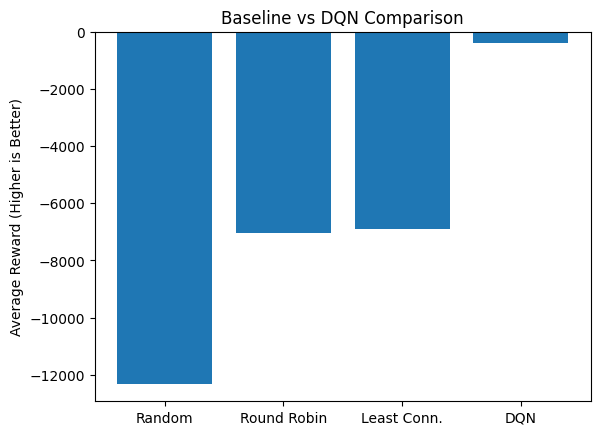

In [51]:
methods = ["Random", "Round Robin", "Least Conn.", "DQN"]
rewards = [r_reward, rr_reward, lc_reward, dqn_reward]

plt.figure()
plt.bar(methods, rewards)
plt.title("Baseline vs DQN Comparison")
plt.ylabel("Average Reward (Higher is Better)") 
plt.show()

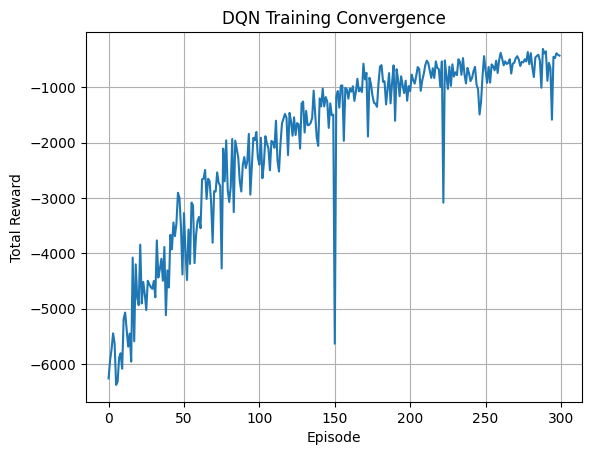

In [52]:
rewards = np.load(REWARD_PATH)
plt.figure()
plt.plot(rewards)
plt.title("DQN Training Convergence")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid()
plt.show()

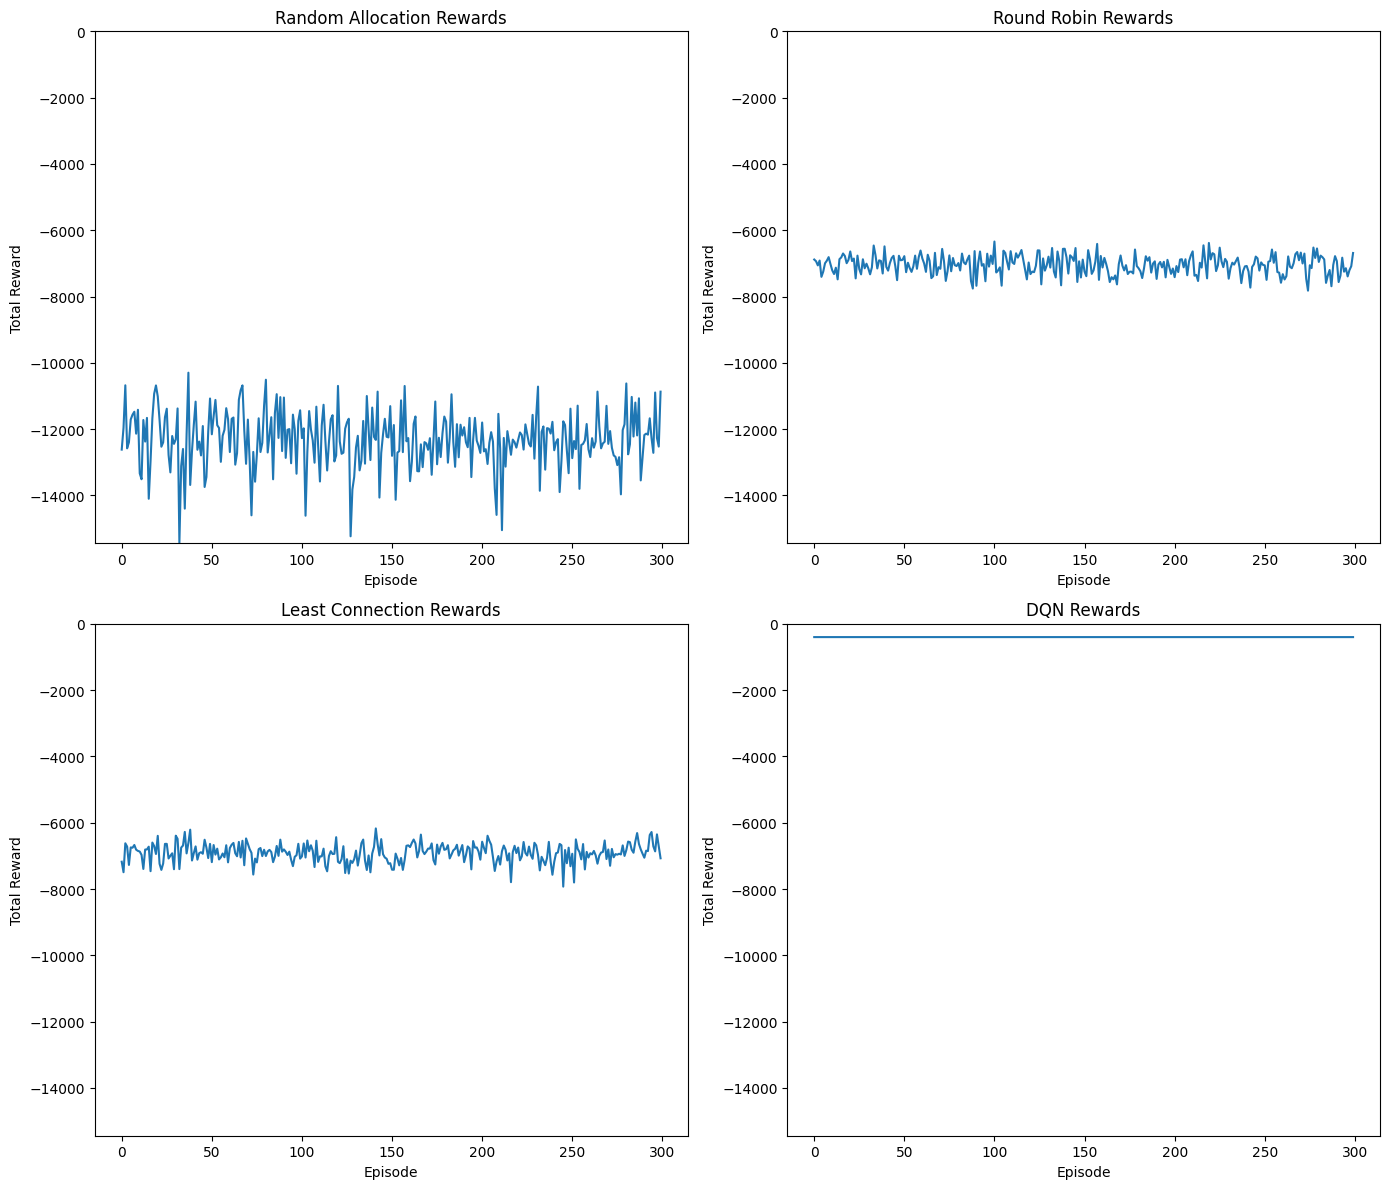

In [54]:
minimum = min(min(r_results), min(rr_results), min(lc_results), min(dqn_results))

plt.figure(figsize = (14, 12))

plt.subplot(2, 2, 1)
plt.title("Random Allocation Rewards")
plt.ylim(minimum, 0)
plt.plot(r_results)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.tight_layout()

plt.subplot(2, 2, 2)
plt.title("Round Robin Rewards")
plt.ylim(minimum, 0)
plt.plot(rr_results)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.tight_layout()

plt.subplot(2, 2, 3)
plt.title("Least Connection Rewards")
plt.ylim(minimum, 0)
plt.plot(lc_results)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.tight_layout()

plt.subplot(2, 2, 4)
plt.title("DQN Rewards")
plt.ylim(minimum, 0)
plt.plot(dqn_results)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.tight_layout()

plt.show()